# A1.5 Solución de problemas

In [1]:
# Exportación de librerías.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm

#### 1. Abajo, se imprime el tipo de datos que hay en el dataframe de la base de datos "A1.5 Calificaciones".

In [2]:
data = pd.read_csv("A1.5 Calificaciones.csv")
print(data.head(1),'\n')
print(data.dtypes)

  Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  G3
0      GP    F    18               2           0       no       6   5   6   6 

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


#### 2. La variables de internet, sexo y escuela se tratan con dummy encoding, se generarán nuevas columnas para nuestro modelo de regresión. El resultado será 1 si es positiva la selección y 0 con falso dependiendo del caso en cada columna. 

In [3]:
data = pd.get_dummies(data,columns=["Escuela","Sexo","Internet"])
print(data.head(1))
print(data.dtypes)

   Edad  HorasDeEstudio  Reprobadas  Faltas  G1  G2  G3  Escuela_GP  \
0    18               2           0       6   5   6   6           1   

   Escuela_MS  Sexo_F  Sexo_M  Internet_no  Internet_yes  
0           0       1       0            1             0  
Edad              int64
HorasDeEstudio    int64
Reprobadas        int64
Faltas            int64
G1                int64
G2                int64
G3                int64
Escuela_GP        uint8
Escuela_MS        uint8
Sexo_F            uint8
Sexo_M            uint8
Internet_no       uint8
Internet_yes      uint8
dtype: object


#### 3. Mediante el método de Tukey, se calculan los límites de Tukey a través del rango intercuartílico, que se aplicaran sobre la columna faltas, de tal forma que se trabajen únicamente con valores centrales y significativos. Después de identificarlos, se retiran del conjunto de datos para la generación del modelo. 

In [4]:
Q1 = data["Faltas"].quantile(0.25)
Q3 = data["Faltas"].quantile(0.75)

IQR = Q3 - Q1

lower_b = Q1-3*IQR
upper_b = Q3+3*IQR

print("Lower bound: ", lower_b)
print("Upper bound: ", upper_b,"\n")

outliers = data[(data["Faltas"] < lower_b) | (data["Faltas"] > upper_b)]
print("Los valores atípicos en la columna Faltas son: \n", outliers["Faltas"])

Lower bound:  -24.0
Upper bound:  32.0 

Los valores atípicos en la columna Faltas son: 
 74     54
183    56
276    75
307    38
315    40
Name: Faltas, dtype: int64


#### 4. Se generá una matriz de correlaciones para detectar problemas de colinealidad en las variables independientes.

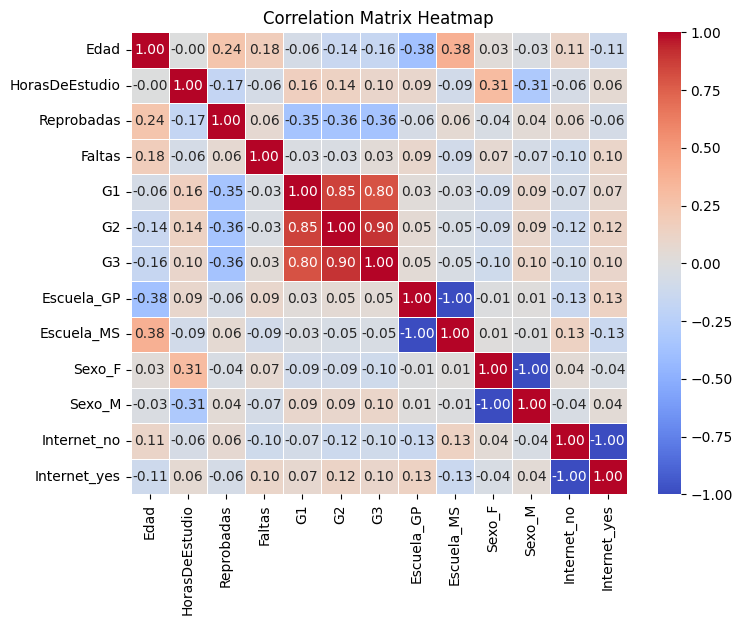

Variables que deben ser removidas por colinealidad alta: {'G3', 'G2', 'G1'}


In [ ]:
corr_matrix = data.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()
high_corr_vars = set()
threshold = 0.8

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if(corr_matrix.iloc[i, j]>threshold):
            high_corr_vars.add(corr_matrix.columns[j])
            high_corr_vars.add(corr_matrix.columns[i])
        
# Print analysis
if high_corr_vars:
    print(f"Variables que deben ser removidas por colinealidad alta: {high_corr_vars}")
    # data.drop(columns=high_corr_vars, inplace=True)  # Se eliminan
else:
    print("Ninguna variable debe ser removida.")


# Arguments for colinearity: https://stats.stackexchange.com/questions/434100/can-collinear-variables-be-justified-because-both-matter


#### A través de estos resultados, podemos indicar que G1, G2 y G3 representan información que está muy relacionada entre sí, uno pudiera optar por dejar únicamente G3, no obstante, se optará por dejar todas las variables independientes ya que se puede esperar que los resultados de un periodo influyan signficativamente a otros.

#### 5. Los posible términos de interacción en el modelo serán las variables de las faltas y la calificación final, ya que el interés y el tiempo dedicado a los temas del cursos suelen tender a disminuir por cada una. Igualmente, se incluirá una relación entre la cantidad de materias reprobadas y la calificación final, ya que su impacto en la nota se esperaría que sea más evidente.

In [6]:
data["Faltas_G3_Interaccion"] = data["Faltas"]*data["G3"]
data["Reprobadas_G3_Interaccion"] = data["Reprobadas"]*data["G3"]
print(data.head(5))

   Edad  HorasDeEstudio  Reprobadas  Faltas  G1  G2  G3  Escuela_GP  \
0    18               2           0       6   5   6   6           1   
1    17               2           0       4   5   5   6           1   
2    15               2           3      10   7   8  10           1   
3    15               3           0       2  15  14  15           1   
4    16               2           0       4   6  10  10           1   

   Escuela_MS  Sexo_F  Sexo_M  Internet_no  Internet_yes  \
0           0       1       0            1             0   
1           0       1       0            0             1   
2           0       1       0            0             1   
3           0       1       0            0             1   
4           0       1       0            1             0   

   Faltas_G3_Interaccion  Reprobadas_G3_Interaccion  
0                     36                          0  
1                     24                          0  
2                    100                         3

#### 6. Modelo de regresión lineal múltiple. Se genera una gráfica con base a los datos obtenidos.

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     182.1
Date:                Wed, 19 Feb 2025   Prob (F-statistic):          1.15e-126
Time:                        19:00:44   Log-Likelihood:                -609.20
No. Observations:                 316   AIC:                             1242.
Df Residuals:                     304   BIC:                             1287.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

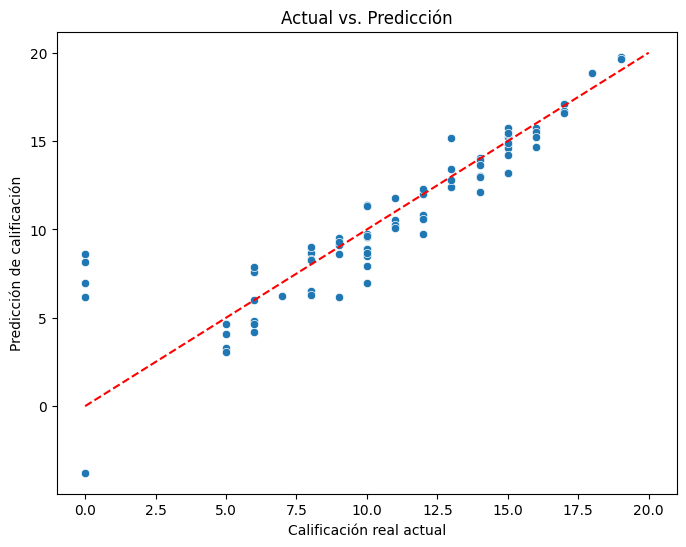


Conclusión: El modelo tiene una correlación igual a 0.89 entre los valores actuales y los predecidos. Al ser la correlación cercana a 1, el modelo tiene una buena capacidad de predicción.


In [7]:
model = LinearRegression()
X = data[["Edad","HorasDeEstudio","Reprobadas","Faltas","G1","G2","Escuela_GP","Escuela_MS","Sexo_F","Sexo_M","Internet_no","Internet_yes","Faltas_G3_Interaccion","Reprobadas_G3_Interaccion"]]
y = data["G3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()

# Resumen
print(model.summary())

# Predicción con los valores de prueba
y_pred = model.predict(X_test_const)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 20], [0, 20], color='red', linestyle='--')
plt.xlabel("Calificación real actual")
plt.ylabel("Predicción de calificación")
plt.title("Actual vs. Predicción")
plt.show()

correlation = np.corrcoef(y_test, y_pred)[0,1]
print(f"\nConclusión: El modelo tiene una correlación igual a {correlation:.2f} entre los valores actuales y los predecidos. "
      "Al ser la correlación cercana a 1, el modelo tiene una buena capacidad de predicción.")


#### Adicionalmente, se puede establecer que la suposición inicial de incluir la interacción de Faltas y calificación final no tiene una relación estadística suficiente (t < -1.96 es falso) (p < 0.05 es falso), así como las variables, Internet_no, Internet_yes, Sexo_F, Sexo_M y HorasDeEstudio. Faltas falla en rechazar la hipótesis nula, por lo que no se puede asegurar su valor t de manera confiable. Por lo tanto, se debería considerar retirar o replantear algunas de estas variables.

#### Código de honor: Doy mi palabra de que he realizado esta actividad con integridad académica.